In [1]:
from google.colab import drive
drive.mount('/content/drive')

KP_ROOT  ="/content/drive/MyDrive/variable-keypoints"
JSON_DIR = f"{KP_ROOT}/Cutdown-json"

TRAIN_MAN = f"{JSON_DIR}/Train_150_kp_variable.json"
VAL_MAN   = f"{JSON_DIR}/Valid_150_kp_variable.json"
TEST_MANS = {
    "ITW": f"{JSON_DIR}/Test_ITW_150_kp_variable.json",
    "STU": f"{JSON_DIR}/Test_STU_150_kp_variable.json",
    "SYN": f"{JSON_DIR}/Test_SYN_150_kp_variable.json",
    "TED": f"{JSON_DIR}/Test_TED_150_kp_variable.json",
}

CALLBACK_DIR = f"{KP_ROOT}/model-callbacks-keras"
MODEL_PATH   = f"{CALLBACK_DIR}/bilstm_best.keras"

import os, json, numpy as np, tensorflow as tf
from pathlib import Path
os.makedirs(CALLBACK_DIR, exist_ok=True)

print("KP_ROOT:", KP_ROOT)
print("JSON_DIR:", JSON_DIR)


Mounted at /content/drive
KP_ROOT: /content/drive/MyDrive/variable-keypoints
JSON_DIR: /content/drive/MyDrive/variable-keypoints/Cutdown-json


In [2]:
import json, numpy as np, os
from pathlib import Path, PureWindowsPath  # <- added PureWindowsPath

LABEL_MAP_JSON = f"{KP_ROOT}/label_map.json"
STATS_JSON     = f"{KP_ROOT}/stats.json"

def build_label_map(train_manifest, out_json):
    with open(train_manifest, "r", encoding="utf-8") as f:
        d = json.load(f)
    glosses = sorted({v["gloss"] for _, v in d.items()})
    lm = {g:i for i,g in enumerate(glosses)}
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(lm, f, indent=2, ensure_ascii=False)
    print(f"Saved label_map to {out_json} with {len(lm)} classes.")
    return out_json

def compute_stats(train_manifest, kp_root, out_json, max_items=None):
    with open(train_manifest, "r", encoding="utf-8") as f:
        items = list(json.load(f).items())

    feats = []
    take = items if max_items is None else items[:max_items]
    for _, meta in take:
        # normalize manifest path that may contain backslashes
        p = Path(kp_root) / Path(PureWindowsPath(meta["npz"]))
        if not p.exists():
            raise FileNotFoundError(f"Missing file referenced in manifest: {p}")
        d = np.load(p)
        x = d["x"].astype(np.float32).reshape(d["x"].shape[0], -1)  # [T,84]
        m = d["m"].astype(np.float32)                               # [T,42]
        m_feat = np.repeat(m, 2, axis=1)                            # [T,84]
        x = x * m_feat
        feats.append(x)

    X = np.concatenate(feats, axis=0)  # [N*T,84]
    mu = X.mean(axis=0).tolist()
    sd = X.std(axis=0).tolist()
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump({"mean": mu, "std": sd}, f)
    print(f"Saved stats to {out_json}")
    return out_json

if not os.path.exists(LABEL_MAP_JSON):
    build_label_map(TRAIN_MAN, LABEL_MAP_JSON)
else:
    print("label_map.json already exists")

if not os.path.exists(STATS_JSON):
    compute_stats(TRAIN_MAN, KP_ROOT, STATS_JSON)  # set max_items if you want a quick pass
else:
    print("stats.json already exists")

# quick peek
with open(LABEL_MAP_JSON, "r", encoding="utf-8") as f:
    lm = json.load(f)
print("Classes:", len(lm))


label_map.json already exists
Saved stats to /content/drive/MyDrive/variable-keypoints/stats.json
Classes: 109


In [3]:
import tensorflow as tf
import numpy as np
import json, os
from pathlib import Path, PureWindowsPath


with open(LABEL_MAP_JSON, "r", encoding="utf-8") as f:
    label_map = json.load(f)
inv_label = {v:k for k,v in label_map.items()}

with open(STATS_JSON, "r") as f:
    stats = json.load(f)
mu = np.array(stats["mean"], dtype=np.float32)
sd = np.array(stats["std"],  dtype=np.float32)
sd[sd < 1e-6] = 1.0

# Variable-length sequence support
F = 84  # Still 84 features (42 points × 2 coords)
MAX_T = 300  # Maximum sequence length for padding

def resolve_npz(npz_rel):

    rel = Path(PureWindowsPath(npz_rel))
    return str(Path(KP_ROOT) / rel)

def load_index(man_path):
    with open(man_path, "r", encoding="utf-8") as f:
        d = json.load(f)
    items = []
    for _, meta in d.items():
        items.append((meta["npz"], label_map[str(meta["gloss"])]))
    return items

def _decode_tf_string(s):
    if hasattr(s, "numpy"):
        return s.numpy().decode("utf-8")
    if isinstance(s, (bytes, bytearray, np.bytes_)):
        return bytes(s).decode("utf-8")
    if isinstance(s, str):
        return s
    return str(s)

def npz_to_example(npz_rel, y):
    """Load variable-length keypoint sequence."""
    p = resolve_npz(_decode_tf_string(npz_rel))
    d = np.load(p)
    x = d["x"].astype(np.float32)       # [T_actual, 42, 2] - Variable T!
    m = d["m"].astype(np.float32)       # [T_actual, 42]

    T_actual = x.shape[0]

    # Flatten and apply mask
    x = x.reshape(T_actual, -1)         # [T_actual, 84]
    m_feat = np.repeat(m, 2, axis=1)    # [T_actual, 84]
    x = x * m_feat                      # Zero out missing points
    x = (x - mu) / sd                   # Z-score normalization

    # Pad to MAX_T if needed
    if T_actual < MAX_T:
        pad_len = MAX_T - T_actual
        x = np.pad(x, ((0, pad_len), (0, 0)), mode='constant', constant_values=0.0)
    elif T_actual > MAX_T:
        # Truncate if longer than max (rare, but safety)
        x = x[:MAX_T]

    return x, np.int32(y)

def tf_load(npz_rel, y):
    """TensorFlow wrapper for loading."""
    x, y = tf.py_function(
        func=npz_to_example,
        inp=[npz_rel, y],
        Tout=[tf.float32, tf.int32]
    )
    x.set_shape([MAX_T, F])  # Padded to max length, masking will ignore padding
    y.set_shape([])
    return x, y

def make_dataset(man_path, bsz=128, shuffle=True):
    items = load_index(man_path)
    paths = tf.constant([p for p,_ in items], dtype=tf.string)
    ys    = tf.constant([y for _,y in items], dtype=tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((paths, ys))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(items), reshuffle_each_iteration=True)
    ds = ds.map(tf_load, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(bsz).prefetch(tf.data.AUTOTUNE)
    return ds, len(items)

BATCH = 128
train_ds, Ntrain = make_dataset(TRAIN_MAN, bsz=BATCH, shuffle=True)
val_ds,   Nval   = make_dataset(VAL_MAN,   bsz=BATCH, shuffle=False)
print("Ntrain:", Ntrain, "Nval:", Nval, "| Classes:", len(label_map))
print(f"Sequences padded to MAX_T={MAX_T} frames (masking handles variable lengths)")


Ntrain: 1306 Nval: 217 | Classes: 109
Sequences padded to MAX_T=300 frames (masking handles variable lengths)


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = len(label_map)

def build_model(MAX_T=300, F=84, C=NUM_CLASSES):
    inp = keras.Input(shape=(MAX_T, F), name="seq")
    x = layers.Masking(mask_value=0.0)(inp)

    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(C, activation="softmax")(x)

    model = keras.Model(inp, out, name="bilstm_kp")
    return model

model = build_model(MAX_T, F, NUM_CLASSES)
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


Model: "bilstm_kp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq (InputLayer)    │ (None, 300, 84)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 300, 84)   │          0 │ seq[0][0]         │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 300, 84)   │          0 │ seq[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 300)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 300, 512)  │    698,368 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 300, 512)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 512)       │  1,574,912 │ dropout[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 109)       │     28,013 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,432,621 (9.28 MB)

 Trainable params: 2,432,621 (9.28 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

ckpt = ModelCheckpoint(
    MODEL_PATH,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False,   # Keras v3 SavedModel/keras format
    verbose=1
)
lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)
log = CSVLogger(f"{CALLBACK_DIR}/train_log.csv")

callbacks = [ckpt, lr, es, log]
print("Callbacks will save to:", CALLBACK_DIR)


Callbacks will save to: /content/drive/MyDrive/variable-keypoints/model-callbacks-keras


In [6]:
EPOCHS = 60
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
print("Best model saved at:", MODEL_PATH)


Epoch 1/60
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.0211 - loss: 4.6711
Epoch 1: val_accuracy improved from -inf to 0.05991, saving model to /content/drive/MyDrive/variable-keypoints/model-callbacks-keras/bilstm_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.0219 - loss: 4.6654 - val_accuracy: 0.0599 - val_loss: 4.3905 - learning_rate: 0.0010
Epoch 2/60
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.0827 - loss: 4.2240
Epoch 2: val_accuracy improved from 0.05991 to 0.14286, saving model to /content/drive/MyDrive/variable-keypoints/model-callbacks-keras/bilstm_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 338ms/step - accuracy: 0.0845 - loss: 4.2091 - val_accuracy: 0.1429 - val_loss: 3.8583 - learning_rate: 0.0010
Epoch 3/60
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.1380 - loss: 3.6274
Epoch 3: val_accuracy improved from 0.14286 to 0.18894, saving model to /content/drive/MyDrive/variable-keypoints/model-callbacks-keras/bilstm_best.keras
11/

In [7]:
# === Smart (re)train cell: never start from scratch ===
import os, csv, tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

# 1) Build or load model
if os.path.exists(MODEL_PATH):
    print(f"[Resume] Loading best model from:\n  {MODEL_PATH}")
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)
else:
    print("[Fresh] No saved model found — building a new one.")
    model = build_model(T, F, NUM_CLASSES)

# (Re)compile (safe even when resuming)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 2) Where to continue from?
log_path = os.path.join(CALLBACK_DIR, "train_log.csv")
initial_epoch = 0
if os.path.exists(log_path):
    try:
        with open(log_path, "r", newline="") as f:
            n_epochs_logged = sum(1 for _ in csv.DictReader(f))
        initial_epoch = n_epochs_logged
        print(f"[Resume] Found CSV log with {n_epochs_logged} completed epoch(s). "
              f"Continuing from epoch {initial_epoch}.")
    except Exception as e:
        print(f"[Warn] Could not parse CSV log: {e}")

# 3) Callbacks (append to CSV; keep saving best on val_accuracy)
ckpt = ModelCheckpoint(
    MODEL_PATH,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)
lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)
log = CSVLogger(log_path, append=True)

callbacks = [ckpt, lr, es, log]
print("Callbacks dir:", CALLBACK_DIR)

# 4) Train more (or the first time)
#    If you just want to *skip* training and only evaluate, set DO_TRAIN=False.
DO_TRAIN = True
if DO_TRAIN:
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        initial_epoch=initial_epoch,
        callbacks=callbacks,
        verbose=1,
    )
    print("Best model (so far) saved at:", MODEL_PATH)
else:
    print("Training skipped (DO_TRAIN=False). You can evaluate with the loaded model.")


[Resume] Loading best model from:
  /content/drive/MyDrive/variable-keypoints/model-callbacks-keras/bilstm_best.keras
[Resume] Found CSV log with 31 completed epoch(s). Continuing from epoch 31.
Callbacks dir: /content/drive/MyDrive/variable-keypoints/model-callbacks-keras
Epoch 32/60
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9248 - loss: 0.2600
Epoch 32: val_accuracy improved from -inf to 0.58065, saving model to /content/drive/MyDrive/variable-keypoints/model-callbacks-keras/bilstm_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 385ms/step - accuracy: 0.9210 - loss: 0.2692 - val_accuracy: 0.5806 - val_loss: 1.9096 - learning_rate: 0.0010
Epoch 33/60
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8904 - loss: 0.3431
Epoch 33: val_accuracy improved from 0.58065 to 0.58525, saving model to /content/drive/MyDrive/variable-keypoints/model-callbacks-keras/bilstm_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.8910 - loss: 0.3423 - val_accuracy: 0.5853 - val_

In [8]:
import numpy as np
from collections import defaultdict

# reload best
best_model = tf.keras.models.load_model(MODEL_PATH)

def topk_acc(y_true, y_prob, k=5):
    topk = np.argpartition(-y_prob, kth=range(k), axis=1)[:, :k]
    return (topk == y_true[:, None]).any(axis=1).mean()

def evaluate_manifest(name, man_path, batch=256):
    ds, N = make_dataset(man_path, bsz=batch, shuffle=False)
    y_true = []
    y_prob = []
    for xb, yb in ds:
        pb = best_model(xb, training=False).numpy()
        y_prob.append(pb)
        y_true.append(yb.numpy())
    y_true = np.concatenate(y_true)
    y_prob = np.concatenate(y_prob)
    y_pred = y_prob.argmax(1)
    acc1 = (y_pred == y_true).mean()
    acc5 = topk_acc(y_true, y_prob, k=5)
    print(f"{name:>4} | top-1 {acc1:.3f} | top-5 {acc5:.3f} | N={len(y_true)}")
    return y_true, y_prob

print("=== Test splits ===")
test_results = {}
for k, p in TEST_MANS.items():
    y_true, y_prob = evaluate_manifest(k, p)
    test_results[k] = (y_true, y_prob)


=== Test splits ===
 ITW | top-1 0.638 | top-5 0.890 | N=218
 STU | top-1 0.748 | top-5 0.950 | N=218
 SYN | top-1 0.518 | top-5 0.766 | N=218
 TED | top-1 0.575 | top-5 0.811 | N=212


In [9]:
import numpy as np

def inv(idx): return {v:k for k,v in label_map.items()}[idx]

def show_samples(man_path, n=10):
    ds, _ = make_dataset(man_path, bsz=1, shuffle=False)
    inv_map = {v:k for k,v in label_map.items()}
    shown = 0
    for xb, yb in ds:
        prob = best_model(xb, training=False).numpy()[0]
        top5 = prob.argsort()[-5:][::-1]
        true_idx = int(yb.numpy()[0])
        print(f"[{shown}] true: {inv_map[true_idx]:>12} | pred@5: {[inv_map[i] for i in top5]}")
        shown += 1
        if shown >= n: break

print("Sample predictions from ITW:")
show_samples(TEST_MANS["ITW"], n=10)


Sample predictions from ITW:
[0] true:      BROTHER | pred@5: ['BROTHER', 'D', 'BUT', 'K', 'STRONG']
[1] true:         LOVE | pred@5: ['LOVE', 'Y', 'DO', 'I', 'STOP']
[2] true:         LOVE | pred@5: ['Y', 'STOP', 'LOVE', 'I', 'WHAT']
[3] true:        HELLO | pred@5: ['HELLO', 'LISTEN', 'STOP', 'GO', 'B']
[4] true:            Y | pred@5: ['N', 'IT', 'DO', 'SMALL', 'WHAT']
[5] true:            H | pred@5: ['H', 'BOY', 'LIKE', 'MAN', 'EYE']
[6] true:         HAND | pred@5: ['HAND', 'BOOK', 'NIGHT', 'FRIEND', 'CHAIR']
[7] true:            N | pred@5: ['YOU', 'N', 'NO', 'P', 'LOVE']
[8] true:      TEACHER | pred@5: ['X', 'TEACHER', 'T', 'R', 'EAR']
[9] true:      HOLIDAY | pred@5: ['HOLIDAY', 'WE', 'HOUSE', 'STOP', 'GO']


In [10]:
!pip -q install scikit-learn
from sklearn.metrics import confusion_matrix
import numpy as np

def confusion_for_split(man_key):
    y_true, y_prob = test_results[man_key]
    y_pred = y_prob.argmax(1)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    print("Confusion matrix shape:", cm.shape)
    return cm

cm_itw = confusion_for_split("ITW")


Confusion matrix shape: (109, 109)


In [11]:
# --- Summarize test-set accuracies (top-1/top-5) and save as CSV ---
import numpy as np
import pandas as pd

def evaluate_to_dict(name, man_path):
    ds, _ = make_dataset(man_path, bsz=256, shuffle=False)
    y_true = []
    y_prob = []
    for xb, yb in ds:
        pb = best_model(xb, training=False).numpy()
        y_prob.append(pb)
        y_true.append(yb.numpy())
    y_true = np.concatenate(y_true)
    y_prob = np.concatenate(y_prob)
    y_pred = y_prob.argmax(1)
    top1 = (y_pred == y_true).mean()
    # top-5
    top5_hits = []
    top5_idx = np.argpartition(-y_prob, kth=range(5), axis=1)[:, :5]
    top5 = (top5_idx == y_true[:, None]).any(axis=1).mean()
    return {"split": name, "N": len(y_true), "top1": float(top1), "top5": float(top5)}

rows = []
for split_name, man_path in TEST_MANS.items():
    rows.append(evaluate_to_dict(split_name, man_path))

df = pd.DataFrame(rows).sort_values("split")
display(df.style.format({"top1": "{:.3f}", "top5": "{:.3f}"}))

csv_path = f"{CALLBACK_DIR}/test_summary.csv"
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)


,split,N,top1,top5
0,ITW,218,0.638,0.890
1,STU,218,0.748,0.950
2,SYN,218,0.518,0.766
3,TED,212,0.575,0.811


Saved: /content/drive/MyDrive/variable-keypoints/model-callbacks-keras/test_summary.csv


In [12]:
# --- Per-class accuracy for one split (e.g., ITW) ---
split_key = "ITW"  # change to "STU", "SYN", "TED" as needed
ds, _ = make_dataset(TEST_MANS[split_key], bsz=256, shuffle=False)

all_true, all_pred = [], []
for xb, yb in ds:
    pb = best_model(xb, training=False).numpy()
    all_true.append(yb.numpy())
    all_pred.append(pb.argmax(1))

y_true = np.concatenate(all_true)
y_pred = np.concatenate(all_pred)

inv_map = {v:k for k,v in label_map.items()}
classes = sorted(label_map.values())
accs = []
for c in classes:
    mask = (y_true == c)
    if mask.sum() == 0:
        acc = np.nan
    else:
        acc = (y_pred[mask] == c).mean()
    accs.append({"gloss": inv_map[c], "acc": acc, "count": int(mask.sum())})

df_cls = pd.DataFrame(accs).sort_values(["count","acc"], ascending=[False,False])
display(df_cls.head(20).style.format({"acc": "{:.3f}"}))  # top 20 by support


,gloss,acc,count
1,ARM,1.000,2
3,BABY,1.000,2
5,BED,1.000,2
6,BIG,1.000,2
7,BODY,1.000,2
8,BOOK,1.000,2
11,BROTHER,1.000,2
13,C,1.000,2
14,CHAIR,1.000,2
17,D,1.000,2


In [13]:
# === Per-class metrics for ALL 109 words across all test splits + pooled ===
import numpy as np
import pandas as pd

# assumes you already have:
# - best_model   (tf.keras.Model, loaded)
# - TEST_MANS    (dict: {"ITW": "...", "STU": "...", "SYN": "...", "TED": "..."})
# - label_map    (dict: gloss -> id)
# - make_dataset (function returning tf.data.Dataset)
# - CALLBACK_DIR (string path)

inv_map = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

def preds_and_labels(manifest_path, bsz=256):
    ds, _ = make_dataset(manifest_path, bsz=bsz, shuffle=False)
    probs, labels = [], []
    for xb, yb in ds:
        pb = best_model(xb, training=False).numpy()
        probs.append(pb)
        labels.append(yb.numpy())
    if not probs:
        return np.zeros((0, num_classes), dtype=np.float32), np.zeros((0,), dtype=np.int64)
    return np.concatenate(probs, 0), np.concatenate(labels, 0)

def per_class_metrics(y_true, y_prob):
    """Return DataFrame with columns: gloss, count, top1, top5."""
    y_pred = y_prob.argmax(1)
    # top-5 membership
    # faster than full sort:
    top5_idx = np.argpartition(-y_prob, kth=4, axis=1)[:, :5]

    rows = []
    for cid in range(num_classes):
        mask = (y_true == cid)
        n = int(mask.sum())
        if n == 0:
            rows.append({"gloss": inv_map[cid], "count": 0, "top1": np.nan, "top5": np.nan})
            continue
        top1 = float((y_pred[mask] == cid).mean())
        top5 = float((top5_idx[mask] == cid).any(axis=1).mean())
        rows.append({"gloss": inv_map[cid], "count": n, "top1": top1, "top5": top5})
    return pd.DataFrame(rows)

# collect per-split frames
split_frames = {}
all_probs = []
all_labels = []

for split_key, man_path in TEST_MANS.items():  # e.g., {"ITW": "...", ...}
    probs, labels = preds_and_labels(man_path, bsz=256)
    all_probs.append(probs)
    all_labels.append(labels)
    df = per_class_metrics(labels, probs)
    df = df.rename(columns={
        "count": f"count_{split_key}",
        "top1":  f"top1_{split_key}",
        "top5":  f"top5_{split_key}",
    })
    split_frames[split_key] = df

# pooled "ALL" across test sets
if all_probs:
    probs_all = np.concatenate(all_probs, 0)
    labels_all = np.concatenate(all_labels, 0)
else:
    probs_all = np.zeros((0, num_classes), dtype=np.float32)
    labels_all = np.zeros((0,), dtype=np.int64)

df_all = per_class_metrics(labels_all, probs_all).rename(columns={
    "count": "count_ALL", "top1": "top1_ALL", "top5": "top5_ALL"
})

# merge everything on gloss
from functools import reduce
dfs_to_merge = [df_all] + [split_frames[k] for k in sorted(split_frames.keys())]
df_merged = reduce(lambda l, r: pd.merge(l, r, on="gloss", how="outer"), dfs_to_merge)

# order columns nicely
col_order = ["gloss",
             "count_ALL", "top1_ALL", "top5_ALL",
             "count_ITW", "top1_ITW", "top5_ITW",
             "count_STU", "top1_STU", "top5_STU",
             "count_SYN", "top1_SYN", "top5_SYN",
             "count_TED", "top1_TED", "top5_TED"]
# keep only existing (in case a split is missing)
col_order = [c for c in col_order if c in df_merged.columns]
df_merged = df_merged[col_order].sort_values("gloss").reset_index(drop=True)

# pretty print & save
pd.set_option("display.max_rows", 1000)
display(df_merged.style.format({c: "{:.3f}" for c in df_merged.columns if c.startswith(("top1","top5"))}))

out_csv = f"{CALLBACK_DIR}/per_class_test_metrics_109.csv"
df_merged.to_csv(out_csv, index=False)
print("Saved per-class test metrics to:", out_csv)


,gloss,count_ALL,top1_ALL,top5_ALL,count_ITW,top1_ITW,top5_ITW,count_STU,top1_STU,top5_STU,count_SYN,top1_SYN,top5_SYN,count_TED,top1_TED,top5_TED
0,A,8,0.625,0.875,2,0.500,1.000,2,1.000,1.000,2,1.000,1.000,2,0.000,0.500
1,ARM,8,0.750,1.000,2,1.000,1.000,2,0.500,1.000,2,1.000,1.000,2,0.500,1.000
2,B,8,0.750,1.000,2,0.500,1.000,2,1.000,1.000,2,1.000,1.000,2,0.500,1.000
3,BABY,8,0.625,1.000,2,1.000,1.000,2,1.000,1.000,2,0.000,1.000,2,0.500,1.000
4,BAD,7,0.571,0.571,2,0.000,0.000,2,0.500,0.500,2,1.000,1.000,1,1.000,1.000
5,BED,8,0.875,1.000,2,1.000,1.000,2,1.000,1.000,2,0.500,1.000,2,1.000,1.000
6,BIG,8,1.000,1.000,2,1.000,1.000,2,1.000,1.000,2,1.000,1.000,2,1.000,1.000
7,BODY,8,0.625,0.750,2,1.000,1.000,2,0.500,1.000,2,0.500,0.500,2,0.500,0.500
8,BOOK,8,0.875,0.875,2,1.000,1.000,2,1.000,1.000,2,0.500,0.500,2,1.000,1.000
9,BOY,8,0.750,0.875,2,0.500,1.000,2,1.000,1.000,2,0.500,0.500,2,1.000,1.000


Saved per-class test metrics to: /content/drive/MyDrive/variable-keypoints/model-callbacks-keras/per_class_test_metrics_109.csv


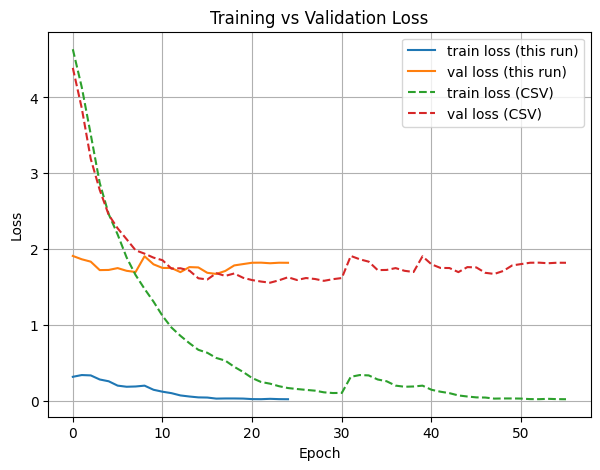

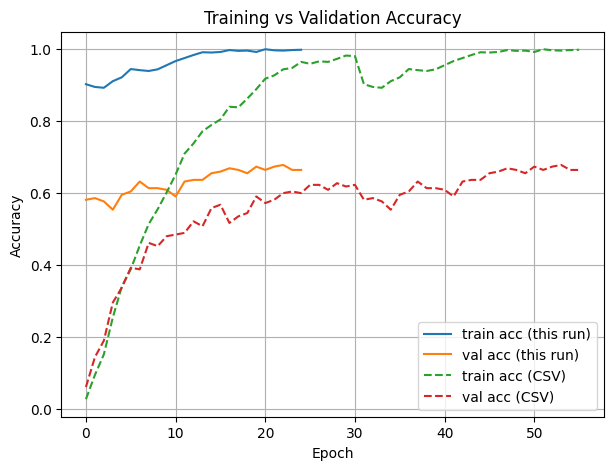

In [14]:
# === Plot training/validation curves (loss & accuracy) ===
import os, csv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

log_path = Path(CALLBACK_DIR) / "train_log.csv"

# 1) Collect from in-memory histories (present run[s])
histories = []
if "history" in globals() and hasattr(history, "history"):
    histories.append(history.history)
if "history2" in globals() and hasattr(history2, "history"):
    histories.append(history2.history)

def concat_histories(hlist, key):
    vals = []
    for h in hlist:
        if key in h:
            vals.extend(h[key])
    return np.array(vals, dtype=float) if vals else None

h_loss  = concat_histories(histories, "loss")
h_vloss = concat_histories(histories, "val_loss")
h_acc   = concat_histories(histories, "accuracy")
h_vacc  = concat_histories(histories, "val_accuracy")

# 2) Also read the CSV log (spans across runs when append=True)
csv_loss = csv_vloss = csv_acc = csv_vacc = None
if log_path.exists():
    loss_list, vloss_list, acc_list, vacc_list = [], [], [], []
    with open(log_path, "r", newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            # Defensive parse (handles missing columns)
            if "loss" in row and row["loss"] != "":
                loss_list.append(float(row["loss"]))
            if "val_loss" in row and row["val_loss"] != "":
                vloss_list.append(float(row["val_loss"]))
            if "accuracy" in row and row["accuracy"] != "":
                acc_list.append(float(row["accuracy"]))
            if "val_accuracy" in row and row["val_accuracy"] != "":
                vacc_list.append(float(row["val_accuracy"]))
    if loss_list:  csv_loss  = np.array(loss_list,  dtype=float)
    if vloss_list: csv_vloss = np.array(vloss_list, dtype=float)
    if acc_list:   csv_acc   = np.array(acc_list,   dtype=float)
    if vacc_list:  csv_vacc  = np.array(vacc_list,  dtype=float)

# === Plot Loss ===
plt.figure(figsize=(7,5))
if h_loss is not None:  plt.plot(h_loss,  label="train loss (this run)")
if h_vloss is not None: plt.plot(h_vloss, label="val loss (this run)")
if csv_loss is not None:  plt.plot(csv_loss,  linestyle="--", label="train loss (CSV)")
if csv_vloss is not None: plt.plot(csv_vloss, linestyle="--", label="val loss (CSV)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# === Plot Accuracy ===
plt.figure(figsize=(7,5))
if h_acc is not None:  plt.plot(h_acc,  label="train acc (this run)")
if h_vacc is not None: plt.plot(h_vacc, label="val acc (this run)")
if csv_acc is not None:  plt.plot(csv_acc,  linestyle="--", label="train acc (CSV)")
if csv_vacc is not None: plt.plot(csv_vacc, linestyle="--", label="val acc (CSV)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()
